## Introducción
En una cafetería estudiantil en la ciudad de León Guanajuato se ha implementado un nuevo método de cobro que se realiza a través de una app, los dueños llevan con este plan Piloto desde hace 4 meses y la intención a futuro es que todas las ventas se realicen sólo en la app. 
Cuando los datos fueron extraídos de la base de datos de la app, los registros representaban un 25% de las ventas totales, por lo que un punto de partida para este análisis sería el predecir en cuanto tiempo le tomará a la cafetería completar la transición, sin embargo para lograr este cometido sería necesario tener a su vez los datos de las ventas físicas, algo que los dueños no tienen debido a su forma de registro de ventas.
El objetivo principal de este proyecto es realiza un análisis general de las ventas y encontrar si hay algún problema del cuál los dueños deban tomar acciones. La toma de decisión debe estar sustentada mediante un modelo predictivo el cuál confirme la teoría encontrada y demuestre las posibles consecuencias en caso de no tomar las medidas pertinentes.
Como comente previamente la extracción de datos se realizo de manera automatica mediante la exportación de lo mismos desde la base de datos de la app, por lo que para comenzar es menester su observación, limpieza y organización en caso de ser necesario.

### Primer paso

In [1]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import statistics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Vamos a importar el dataset

caf = pd.read_csv("cafeteria.csv")

In [3]:
caf.head()

,id,student_uuid,name,amount,quantity,delivery_date,dish_type_name,student_type_name,student_name2,status_name,school_type,section_name,grade,grupo
0,349304,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,150,2,23/09/2024,NaN,Profesor,Erandy Maria Soteldo X,Entregado,NaN,PruebasSecundaria,9.0,E
1,376232,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,15/11/2024,NaN,Profesor,Erandy Maria Soteldo XX,Entregado,NaN,PruebasSecundaria,9.0,E
2,367107,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,28/10/2024,NaN,Profesor,Erandy Maria Soteldo XX,Entregado,NaN,PruebasSecundaria,9.0,E
3,355651,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,225,3,07/10/2024,NaN,Profesor,Erandy Maria Soteldo XX,Entregado,NaN,PruebasSecundaria,9.0,E
4,347311,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,75,1,19/09/2024,NaN,Profesor,Erandy Maria Soteldo XX,Entregado,NaN,PruebasSecundaria,9.0,E


## Limpieza de Datos
Viendo la información que hay en el DataFrame se puede ver que no tenemos la información de género de los estudiantes, algo que es indispensable saber a la hora de realizar el análisis a profundidad por lo que haciendo uso del nombre del estudiante obtendremos su genero.

Para eso debemos manipular el nombre por lo que éste debe encontrarse en un formato "String"

In [5]:
caf["student_name"]= caf["student_name"].astype('string')
caf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4114 entries, 0 to 4113
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4114 non-null   int64  
 1   student_uuid       4114 non-null   object 
 2   name               4114 non-null   object 
 3   amount             4114 non-null   int64  
 4   quantity           4114 non-null   int64  
 5   delivery_date      4114 non-null   object 
 6   dish_type_name     889 non-null    object 
 7   student_type_name  4114 non-null   object 
 8   student_name       4114 non-null   string 
 9   status_name        4114 non-null   object 
 10  school_type        0 non-null      float64
 11  section_name       4114 non-null   object 
 12  grade              3905 non-null   float64
 13  grupo              4114 non-null   object 
dtypes: float64(2), int64(3), object(8), string(1)
memory usage: 450.1+ KB


In [6]:
caf["primer_nombre"] = caf["student_name"].apply(lambda x:x.split(" ")[0])
caf["Genero"] = caf["primer_nombre"].apply(lambda x: "M" if x[-1].lower() in ["a","y"] else
                                          ("H" if x[-1].lower()=="o" else None))
caf["Genero"] 

0          M
1          M
2          M
3          M
4          M
        ... 
4109       M
4110    None
4111    None
4112    None
4113    None
Name: Genero, Length: 4114, dtype: object

Ahora con el paso anterior se asigno un genero a los nombres de alumnos con terminación en "a","y","o" sin embargo, aún hay nombres a los que no les ha sido asignado un genero debido a que o terminan con vocal o son casos especiales. 

In [7]:
nombres = set(caf.loc[pd.isna(caf["Genero"]), "primer_nombre"].tolist())
print(nombres)

{'David', 'Juan', 'Carol', 'Luis', 'Cristobal', 'Nicole', 'Cesar', 'Azul', 'Salvador', 'Luz', 'Bastian', 'Miguel', 'Ian', 'Manuel', 'Andre', 'Gerladine', 'Victor', 'Jose', 'Karim', 'Yamil', 'LIAM', 'Jorge', 'Hermione', 'José', 'Felipe', 'ZAID', 'Ander', 'Matias', 'Nestor', 'Farah', 'Gabriel', 'Joaquin', 'Gael', 'Carlos', 'Alexander', 'Sebastian', 'Samuel', 'Alexis', 'Marian', 'Ramon', 'Ines', 'Ethan'}


Analizando los valores únicos de nombres se puede determinar que los nombres con terminación en "d","m","h" y "r" son nombres de hombre y terminación "z" de mujer.

In [8]:
caf["Genero"] = caf["primer_nombre"].apply(lambda x: "M" if x[-1].lower() in ["a","y","z"] else
                                          ("H" if x[-1].lower() in ["o","d","m","h","r"] else None))

Los nombres con terminación en "l","n","s" y "e" son mixtos por lo que para el tratamiento de éstos últimos se hará un diccionario y se remplazarán los valores de manera manual.

In [9]:
nombres_esp = {
    "Gael":"H",
    "Miguel":"H",
    "Samuel":"H",
    "Gabriel":"H",
    "Yamil":"H",
    "Carol":"M",
    "Manuel":"H",
    "Azul":"M",
    "Marian":"M",
    "Ethan":"H",
    "Ian":"H",
    "Bastian":"H",
    "Juan":"H",
    "Ramon":"H",
    "Sebastian":"H",
    "Joaquin":"H",
    "Hermione":"M",
    "Nicole":"M",
    "Andre":"H",
    "Jose":"H",
    "José":"H",
    "Gerladine":"M",
    "Felipe":"H",
    "Jorge":"H",
    "Luis":"H",
    "Matias":"H",
    "Alexis":"H",
    "Carlos":"H",
    "Ines":"M",
    "Cristobal":"H"
}

In [10]:
caf.loc[pd.isna(caf["Genero"]),"Genero"]=caf.loc[pd.isna(caf["Genero"]),"primer_nombre"].apply(lambda x: nombres_esp.get(x,None))
caf.head()

,id,student_uuid,name,amount,quantity,delivery_date,dish_type_name,student_type_name,student_name,status_name,school_type,section_name,grade,grupo,primer_nombre,Genero
0,349304,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,150,2,2024-09-23,NaN,Profesor,Erandy Olea Soto,Entregado,NaN,PruebasSecundaria,9.0,E,Erandy,M
1,376232,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,2024-11-15,NaN,Profesor,Erandy Olea Soto,Entregado,NaN,PruebasSecundaria,9.0,E,Erandy,M
2,367107,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,2024-10-28,NaN,Profesor,Erandy Olea Soto,Entregado,NaN,PruebasSecundaria,9.0,E,Erandy,M
3,355651,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,225,3,2024-10-07,NaN,Profesor,Erandy Olea Soto,Entregado,NaN,PruebasSecundaria,9.0,E,Erandy,M
4,347311,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,75,1,2024-09-19,NaN,Profesor,Erandy Olea Soto,Entregado,NaN,PruebasSecundaria,9.0,E,Erandy,M


In [11]:
#Ahora vamos a revisar los valores únicos de la columna genero para corroborar que todos los alumnos tengan asignado un genero
print(caf["Genero"].unique())

['M' 'H']


Una vez realizada la columna de genero se puede desechar el nombre del alumno, así como otras columnas que no son necesarias para el alcance de este proyecto *"id"*,*"student_name"*,*"school_type*.


In [12]:
caf = caf.drop(columns=["id","student_name","school_type"])
caf.head()

,student_uuid,name,amount,quantity,delivery_date,dish_type_name,student_type_name,status_name,section_name,grade,grupo,primer_nombre,Genero
0,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,150,2,2024-09-23,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M
1,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,2024-11-15,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M
2,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,2024-10-28,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M
3,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,225,3,2024-10-07,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M
4,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,75,1,2024-09-19,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M


Para terminar con las columnas con las que se estarán trabajando a lo largo del proyecto es necesario crear una nueva columna que indique la venta en pesos por cada transacción.

In [13]:
caf["Precio"] = caf["amount"]/caf["quantity"]
caf.head()

,student_uuid,name,amount,quantity,delivery_date,dish_type_name,student_type_name,status_name,section_name,grade,grupo,primer_nombre,Genero,Precio
0,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,150,2,2024-09-23,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,75.0
1,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,2024-11-15,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,35.0
2,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,2024-10-28,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,35.0
3,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,225,3,2024-10-07,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,75.0
4,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,75,1,2024-09-19,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,75.0


In [14]:
#Revisamos que los formatos concuerden con los datos
caf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4114 entries, 0 to 4113
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   student_uuid       4114 non-null   object 
 1   name               4114 non-null   object 
 2   amount             4114 non-null   int64  
 3   quantity           4114 non-null   int64  
 4   delivery_date      4114 non-null   object 
 5   dish_type_name     889 non-null    object 
 6   student_type_name  4114 non-null   object 
 7   status_name        4114 non-null   object 
 8   section_name       4114 non-null   object 
 9   grade              3905 non-null   float64
 10  grupo              4114 non-null   object 
 11  primer_nombre      4114 non-null   object 
 12  Genero             4114 non-null   object 
 13  Precio             4114 non-null   float64
dtypes: float64(2), int64(2), object(10)
memory usage: 450.1+ KB


Se puede observar como hay parametros que no están en el formato que deberían por lo que es necesario cambiarlo. Además se ve cómo hay valores nulos en ciertas columnas que deberían estar completas, como lo es es grado, y tipo de platillo.


In [15]:
# Cambiar de formato 
caf["delivery_date"] = pd.to_datetime(caf["delivery_date"], errors='coerce')
caf["dish_type_name"] =caf["dish_type_name"].astype('category')
caf["status_name"] = caf["status_name"].astype('category')
caf["section_name"] = caf["section_name"].astype('category')
caf["grade"]= caf["grade"].astype('string') 
caf["grupo"]= caf["grupo"].astype('string')


In [16]:
caf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4114 entries, 0 to 4113
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   student_uuid       4114 non-null   object        
 1   name               4114 non-null   object        
 2   amount             4114 non-null   int64         
 3   quantity           4114 non-null   int64         
 4   delivery_date      4114 non-null   datetime64[ns]
 5   dish_type_name     889 non-null    category      
 6   student_type_name  4114 non-null   object        
 7   status_name        4114 non-null   category      
 8   section_name       4114 non-null   category      
 9   grade              3905 non-null   string        
 10  grupo              4114 non-null   string        
 11  primer_nombre      4114 non-null   object        
 12  Genero             4114 non-null   object        
 13  Precio             4114 non-null   float64       
dtypes: categ

In [17]:
caf.head()

,student_uuid,name,amount,quantity,delivery_date,dish_type_name,student_type_name,status_name,section_name,grade,grupo,primer_nombre,Genero,Precio
0,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,150,2,2024-09-23,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,75.0
1,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,2024-11-15,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,35.0
2,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,2024-10-28,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,35.0
3,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,225,3,2024-10-07,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,75.0
4,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,75,1,2024-09-19,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,75.0


Ahora por simple comodidad se modificarán los nombres de las columnas

In [18]:
caf = caf.rename(columns={'student_uuid':'ID','name':'Producto','amount':'Venta','quantity':'Cantidad','delivery_date':'Fecha','dish_type_name':'Categoria','student_type_name':'Role','status_name':'Estado','section_name':'Nivel','grade':'Grado','grupo':'Grupo'})
caf.head()

,ID,Producto,Venta,Cantidad,Fecha,Categoria,Role,Estado,Nivel,Grado,Grupo,primer_nombre,Genero,Precio
0,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,150,2,2024-09-23,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,75.0
1,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,2024-11-15,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,35.0
2,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,2024-10-28,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,35.0
3,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,225,3,2024-10-07,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,75.0
4,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,75,1,2024-09-19,NaN,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,75.0


Se ha limpiado y dado mayor claridad a los datos, sin embargo viendo el DataFrame se ve que hay que trabajar en los valores faltantes de Categoría, estandarizar los datos de Nivel y modificar el formato de grado ya que aparece como flotante siendo string.

En primer lugar se va a dar a rellenar los valores faltantes en la cateoría Categoría, dependiendo del producto en cuestión para esto el primer paso es determinar los valores únicos en la columna producto y después hacer la categorización.

In [19]:
caf['Producto'].unique().tolist()

['DESAYUNO OPCION 1',
 'ELOTE',
 'REFRESCO',
 'DESAYUNO OPCION 2',
 'PlATILLO DEL DIA',
 'HOT DOG',
 'NACHOS',
 'VASO DE FRUTA',
 'Bebida',
 'DORILOCOS',
 'POWERADE',
 'DESAYUNO OPCION 3',
 'CARLOTA',
 'ARIZONA',
 'HOT CAKES',
 'SOPES',
 'AGUA 1 LT NATURAL',
 'Maicitoz',
 'MANGO ENCHILADO',
 'Pan de muerto',
 'PALETA DE HIELO',
 'PALOMITAS',
 'Welchs',
 'PIÑA ENCHILADA',
 'Susalia',
 'CACAHUATE',
 'AGUA DE FRUTA',
 'snack veggie',
 'CHURROS DE AMARANTO',
 'Platano deshidratado',
 'REBANADA DE PIZZA',
 'Obleas de Amaranto',
 'AGUA 500 ML NATURAL',
 'Sándwich de Helado',
 'OBLEAS DE AMARANTO',
 'PAN CASERO',
 'MOLLETE',
 'Conchita',
 'BOLIS',
 'GELATINA',
 'HUARACHE CON CARNE',
 'SMOOTHIE',
 'TACOS DE GUISADO',
 'TORTAS',
 'SINCRONIZADA',
 'QUESADILLAS CON GUISADO',
 'HAMBURGUESA DE CARNE MAGRA',
 'Galletas de nata',
 'GORDITA DE GUISADO',
 'CEREAL CON LECHE',
 'PAY DE QUESO',
 'Barrita Granola',
 'ARROZ CON LECHE',
 'Plantado deshidratado',
 'Barritas',
 'Empanada',
 'Chips amaranto']

**Al revisar los productos podemos percatarnos que se ha escrito un mismo producto en dos ocasiones debido a un error de dedo, hay que corregirlo para evitar errores más adelante.**

In [20]:
caf["Producto"] = caf["Producto"].replace("Plantado deshidratado","Platano deshidratado")

In [21]:
#Revisamos de que se haya corregido bien
caf['Producto'].unique().tolist()

['DESAYUNO OPCION 1',
 'ELOTE',
 'REFRESCO',
 'DESAYUNO OPCION 2',
 'PlATILLO DEL DIA',
 'HOT DOG',
 'NACHOS',
 'VASO DE FRUTA',
 'Bebida',
 'DORILOCOS',
 'POWERADE',
 'DESAYUNO OPCION 3',
 'CARLOTA',
 'ARIZONA',
 'HOT CAKES',
 'SOPES',
 'AGUA 1 LT NATURAL',
 'Maicitoz',
 'MANGO ENCHILADO',
 'Pan de muerto',
 'PALETA DE HIELO',
 'PALOMITAS',
 'Welchs',
 'PIÑA ENCHILADA',
 'Susalia',
 'CACAHUATE',
 'AGUA DE FRUTA',
 'snack veggie',
 'CHURROS DE AMARANTO',
 'Platano deshidratado',
 'REBANADA DE PIZZA',
 'Obleas de Amaranto',
 'AGUA 500 ML NATURAL',
 'Sándwich de Helado',
 'OBLEAS DE AMARANTO',
 'PAN CASERO',
 'MOLLETE',
 'Conchita',
 'BOLIS',
 'GELATINA',
 'HUARACHE CON CARNE',
 'SMOOTHIE',
 'TACOS DE GUISADO',
 'TORTAS',
 'SINCRONIZADA',
 'QUESADILLAS CON GUISADO',
 'HAMBURGUESA DE CARNE MAGRA',
 'Galletas de nata',
 'GORDITA DE GUISADO',
 'CEREAL CON LECHE',
 'PAY DE QUESO',
 'Barrita Granola',
 'ARROZ CON LECHE',
 'Barritas',
 'Empanada',
 'Chips amaranto']

**Una vez identificados los productos únicos en la columna se crea un diccionario en el que contenga cada producto su categoría.**

In [22]:
producto_categoria = {
    "SOPES":"Antojos",
    "REBANADA DE PIZZA":"Antojos",
    "HUARACHE CON CARNE":"Antojos",
    "TACOS DE GUISADO":"Antojos",
    "TORTAS":"Antojos",
    "SINCRONIZADA":"Antojos",
    "QUESADILLAS CON GUISADO":"Antojos",
    "HAMBURGUESA DE CARNE MAGRA":"Antojos",
    "GORDITA DE GUISADO":"Antojos",
    "REFRESCO":"Bebidas",
    "Bebida":"Bebidas",
    "POWERADE":"Bebidas",
    "ARIZONA":"Bebidas",
    "AGUA 1 LT NATURAL":"Bebidas",
    "AGUA DE FRUTA":"Bebidas",
    "AGUA 500 ML NATURAL":"Bebidas",
    "PALETA DE HIELO":"Congelados",
    "BOLIS":"Congelados",
    "SMOOTHIE":"Congelados",
    "HOT CAKES":"Desayunos",
    "MOLLETE":"Desayunos",
    "CEREAL CON LECHE":"Desayunos",
    "ELOTE":"Fruta",
    "VASO DE FRUTA":"Fruta",
    "MANGO ENCHILADO":"Fruta",
    "Platano deshidratado":"Fruta",
    "PIÑA ENCHILADA":"Fruta",
    "Pan de muerto":"Pan",
    "PAN CASERO":"Pan",
    "Conchita":"Pan",
    "DESAYUNO OPCION 1":"Paquetes",
    "DESAYUNO OPCION 2":"Paquetes",
    "PlATILLO DEL DIA":"Paquetes",
    "DESAYUNO OPCION 3":"Paquetes",
    "CARLOTA":"Postres",
    "Sándwich de Helado":"Postres",
    "GELATINA":"Postres",
    "Galletas de nata":"Postres",
    "PAY DE QUESO":"Postres",
    "ARROZ CON LECHE":"Postres",
    "Empanada":"Postres",
    "HOT DOG":"Snacks",
    "NACHOS":"Snacks",
    "DORILOCOS":"Snacks",
    "Maicitoz":"Snacks",
    "PALOMITAS":"Snacks",
    "Welchs":"Snacks",
    "Susalia":"Snacks",
    "CACAHUATE":"Snacks",
    "snack veggie":"Snacks",
    "CHURROS DE AMARANTO":"Snacks",
    "Obleas de Amaranto":"Snacks",
    "OBLEAS DE AMARANTO":"Snacks",
    "Barrita Granola":"Snacks",
    "Barritas":"Snacks",
    "Chips amaranto":"Snacks"
}

##### El siguiente paso es reemplazar lo valores nulos en la columna categoría con los nuevos valores con base en el diccionario

In [23]:
caf["Categoria"] =caf["Producto"].replace(producto_categoria)

In [24]:
#Corroboramos que se haya hecho la implementación de forma adecuada
caf.head(20)

,ID,Producto,Venta,Cantidad,Fecha,Categoria,Role,Estado,Nivel,Grado,Grupo,primer_nombre,Genero,Precio
0,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,150,2,2024-09-23,Paquetes,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,75.0
1,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,2024-11-15,Fruta,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,35.0
2,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,2024-10-28,Fruta,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,35.0
3,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,225,3,2024-10-07,Paquetes,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,75.0
4,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,75,1,2024-09-19,Paquetes,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,75.0
5,e4b6fcc1ff373ac1e0c7c4a4723df4a6,REFRESCO,25,1,2024-09-09,Bebidas,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,25.0
6,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 2,75,1,2024-09-18,Paquetes,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,75.0
7,e4b6fcc1ff373ac1e0c7c4a4723df4a6,REFRESCO,25,1,2024-09-23,Bebidas,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,25.0
8,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,75,1,2024-09-23,Paquetes,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,75.0
9,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,75,1,2024-09-11,Paquetes,Profesor,Entregado,PruebasSecundaria,9.0,E,Erandy,M,75.0


Ahora queda limpiar los valores para la columna nivel en esencia los valores son los mismos pero escrito de maneras diferentes.

Veamos cuáles son los valores únicos de la columna Nivel

In [26]:
caf["Nivel"] = caf["Nivel"].replace("EspecialdeInglés","Inglés")
caf["Nivel"] = caf["Nivel"].replace("Preprimaria","Kinder")
caf["Nivel"] = caf["Nivel"].replace("KinderII","Kinder")
caf["Nivel"] = caf["Nivel"].replace("PruebasPreescolar","Kinder")
caf["Nivel"] = caf["Nivel"].replace("PreescolarMaternal","Kinder")
caf["Nivel"] = caf["Nivel"].replace("Maternal","Kinder")
caf["Nivel"] = caf["Nivel"].replace("PruebasPrimariaMayor","Primaria")
caf["Nivel"] = caf["Nivel"].replace("PruebasPrimariaMenor","Primaria")
caf["Nivel"] = caf["Nivel"].replace("PrimariaMenor","Primaria")
caf["Nivel"] = caf["Nivel"].replace("PruebasSecundaria","Secundaria")

In [27]:
caf['Nivel'].unique().tolist()

['Secundaria', 'Primaria', 'Inglés', 'Preparatoria', 'Kinder']

In [28]:
caf.head(10)

,ID,Producto,Venta,Cantidad,Fecha,Categoria,Role,Estado,Nivel,Grado,Grupo,primer_nombre,Genero,Precio
0,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,150,2,2024-09-23,Paquetes,Profesor,Entregado,Secundaria,9.0,E,Erandy,M,75.0
1,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,2024-11-15,Fruta,Profesor,Entregado,Secundaria,9.0,E,Erandy,M,35.0
2,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,2024-10-28,Fruta,Profesor,Entregado,Secundaria,9.0,E,Erandy,M,35.0
3,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,225,3,2024-10-07,Paquetes,Profesor,Entregado,Secundaria,9.0,E,Erandy,M,75.0
4,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,75,1,2024-09-19,Paquetes,Profesor,Entregado,Secundaria,9.0,E,Erandy,M,75.0
5,e4b6fcc1ff373ac1e0c7c4a4723df4a6,REFRESCO,25,1,2024-09-09,Bebidas,Profesor,Entregado,Secundaria,9.0,E,Erandy,M,25.0
6,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 2,75,1,2024-09-18,Paquetes,Profesor,Entregado,Secundaria,9.0,E,Erandy,M,75.0
7,e4b6fcc1ff373ac1e0c7c4a4723df4a6,REFRESCO,25,1,2024-09-23,Bebidas,Profesor,Entregado,Secundaria,9.0,E,Erandy,M,25.0
8,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,75,1,2024-09-23,Paquetes,Profesor,Entregado,Secundaria,9.0,E,Erandy,M,75.0
9,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,75,1,2024-09-11,Paquetes,Profesor,Entregado,Secundaria,9.0,E,Erandy,M,75.0


Como último paso en la limpieza de datos en la columna grado se eliminará la parte decimal del número

In [29]:
caf["Grado"] = caf["Grado"].str.replace('.0','',regex=False)
caf.head()

,ID,Producto,Venta,Cantidad,Fecha,Categoria,Role,Estado,Nivel,Grado,Grupo,primer_nombre,Genero,Precio
0,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,150,2,2024-09-23,Paquetes,Profesor,Entregado,Secundaria,9,E,Erandy,M,75.0
1,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,2024-11-15,Fruta,Profesor,Entregado,Secundaria,9,E,Erandy,M,35.0
2,e4b6fcc1ff373ac1e0c7c4a4723df4a6,ELOTE,35,1,2024-10-28,Fruta,Profesor,Entregado,Secundaria,9,E,Erandy,M,35.0
3,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,225,3,2024-10-07,Paquetes,Profesor,Entregado,Secundaria,9,E,Erandy,M,75.0
4,e4b6fcc1ff373ac1e0c7c4a4723df4a6,DESAYUNO OPCION 1,75,1,2024-09-19,Paquetes,Profesor,Entregado,Secundaria,9,E,Erandy,M,75.0


## EDA 
En este apartado estaré análizando las métricas después de haberlas limpiado y estandarizado. Intentando encontrar patrones y preparar los datos para las etapas posteriores.

Dividiremos el análisis dependiendo de los tipos de datos que tenemos los datos númericos y categoricos.

In [30]:
#Datos Númericos (Cantidad, Precio y Venta)
print(f'Para la columna Cantidad sus valores son los siguientes\nMedia:{round(caf["Cantidad"].mean(),2):12}\nMediana:'
                        f'{round(caf["Cantidad"].median(),2):10}\nModa:{round(statistics.mode(caf["Cantidad"]),2):13}')
print(f'Para la columna Precio sus valores son los siguientes\nMedia:{round(caf["Precio"].mean(),2):12}\nMediana:'
                        f'{round(caf["Precio"].median(),2):10}\nModa:{round(statistics.mode(caf["Precio"]),2):13}')
print(f'Para la columna Venta sus valores son los siguientes\nMedia:{round(caf["Venta"].mean(),2):12}\nMediana:'
                        f'{round(caf["Venta"].median(),2):10}\nModa:{round(statistics.mode(caf["Venta"]),2):13}')

Para la columna Cantidad sus valores son los siguientes
Media:        1.07
Mediana:       1.0
Moda:            1
Para la columna Precio sus valores son los siguientes
Media:       45.96
Mediana:      30.0
Moda:         75.0
Para la columna Venta sus valores son los siguientes
Media:       47.93
Mediana:      40.0
Moda:           75


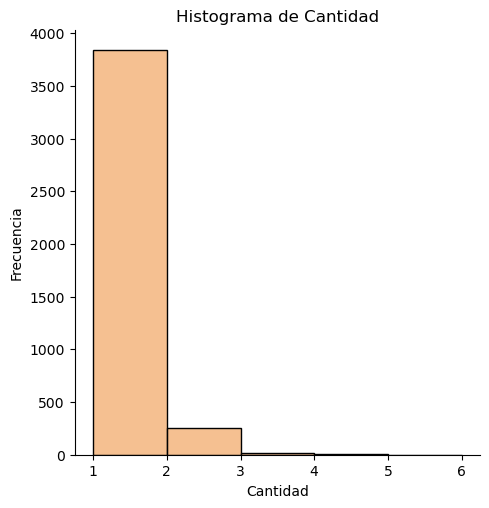

In [31]:
#Histograma de Cantidad por Venta
intervalos_can = range(min(caf["Cantidad"]), max(caf["Cantidad"]) + 1)

sns.displot(caf["Cantidad"], color='#F2AB6D', bins=intervalos_can) 

#configuramos en Matplotlib
plt.xticks(intervalos_can)
plt.ylabel('Frecuencia')
plt.xlabel('Cantidad')
plt.title('Histograma de Cantidad')

plt.show()

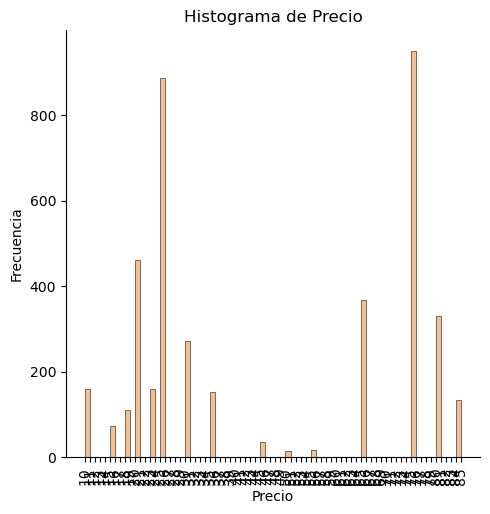

In [32]:
#Histograma de Precio
intervalos_pre = range(int(min(caf["Precio"])), int(max(caf["Precio"])) + 1)

sns.displot(caf["Precio"], color='#F2AB6D', bins=intervalos_pre) 

#configuramos en Matplotlib
plt.xticks(intervalos_pre, rotation=90)
plt.ylabel('Frecuencia')
plt.xlabel('Precio')
plt.title('Histograma de Precio')

plt.show()

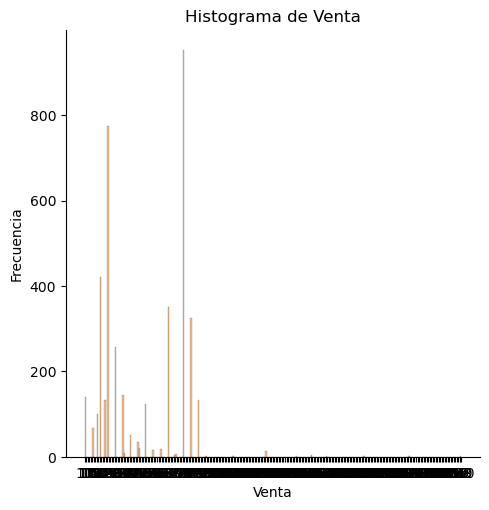

In [33]:
#Histograma de Venta
intervalos_ven = range(min(caf["Venta"]), max(caf["Venta"]) + 1)

sns.displot(caf["Venta"], color='#F2AB6D', bins=intervalos_ven) 
plt.xticks(intervalos_ven)
plt.ylabel('Frecuencia')
plt.xlabel('Venta')
plt.title('Histograma de Venta')

plt.show()

Con base en los histogramas realizados para las columnas númericas se puede observar en la columna "Venta" hay valores atípicos que hacen que podamos encontrar ventas en las cuales el precio de venta fue mucho mayor al promedio. Por otro lado en el Histrograma de Cantidad nos deja claro que mayormente de un producto, sin embargo aquí se debe mencionar que la disposción de  la base de datos nos hace ver que esta venta fue por producto y las ventas debieron agruparse por fecha por estudiante por lo que al hacer la agrupación por fecha el histograma se modificará.
Y por último el Histograma de Precio es de tipo Bimodal lo que indica que hay dos concentraciones en productos con un precio determinado.

Ahora para las columnas con valores categoricos lo que se hará es una revisión de las frecuencias de cada uno de los productos agrupados por categoria. 

C:\Users\Carlos\AppData\Local\Temp\ipykernel_12676\2959907991.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agrupado_categoria = caf.groupby(['Categoria', 'Estado'])['Cantidad'].sum().unstack(fill_value=0)


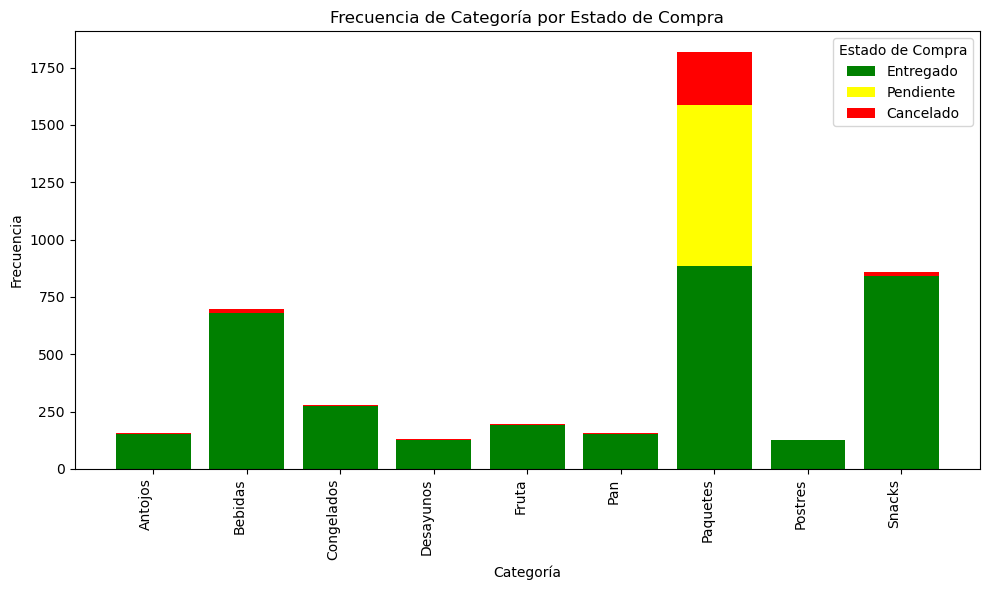

In [34]:
# Agrupación solo por Categoría y Estado
agrupado_categoria = caf.groupby(['Categoria', 'Estado'])['Cantidad'].sum().unstack(fill_value=0)

# Configuración de colores para los estados
colores = {'Entregado': 'green', 'Pendiente': 'yellow', 'Cancelado': 'red'}

# Configuración del gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Crear barras apiladas por categoría
bottom_bar = None  # Inicializar la base de la barra
for estado, color in colores.items():
    if estado in agrupado_categoria.columns:
        valores = agrupado_categoria[estado]
        ax.bar(agrupado_categoria.index, valores, bottom=bottom_bar, color=color, label=estado)
        bottom_bar = valores if bottom_bar is None else bottom_bar + valores

# Configurar etiquetas y leyenda
ax.set_ylabel('Frecuencia')
ax.set_xlabel('Categoría')
ax.set_title('Frecuencia de Categoría por Estado de Compra')
ax.legend(title='Estado de Compra')

plt.xticks(rotation=90, ha='right')  # Rotar etiquetas de las categorías
plt.tight_layout()
plt.show()


In [35]:
porc_cat = caf.groupby(['Categoria', 'Estado'])["Cantidad"].sum().unstack(fill_value=0)
porc_cat = porc_cat[["Entregado","Pendiente","Cancelado"]]
porc_cat["Total"] = porc_cat.sum(axis=1)
for columna in porc_cat.columns: 
    porc_cat[columna + "_%"] = ((porc_cat[columna]/porc_cat["Total"]) * 100).round(2)
print(porc_cat)

Estado      Entregado  Pendiente  Cancelado  Total  Entregado_%  Pendiente_%  \
Categoria                                                                      
Antojos           150          0          5    155        96.77         0.00   
Bebidas           681          0         18    699        97.42         0.00   
Congelados        276          0          2    278        99.28         0.00   
Desayunos         126          0          3    129        97.67         0.00   
Fruta             191          0          4    195        97.95         0.00   
Pan               151          0          7    158        95.57         0.00   
Paquetes          885        702        230   1817        48.71        38.64   
Postres           124          0          2    126        98.41         0.00   
Snacks            842          1         15    858        98.14         0.12   

Estado      Cancelado_%  Total_%  
Categoria                         
Antojos            3.23    100.0  
Bebidas       

C:\Users\Carlos\AppData\Local\Temp\ipykernel_12676\2779690541.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  porc_cat = caf.groupby(['Categoria', 'Estado'])["Cantidad"].sum().unstack(fill_value=0)


Como se puede observar, después de realizar el análisis de estado por categoría se nota como en la mayoría de éstas hay menos del 5% de cancelaciones y un 0% en pedidos pendientes, no obstante de manera puntual en el caso de los Paquetes se observa como menos de la mitad de los pedidos son entregados.

C:\Users\Carlos\AppData\Local\Temp\ipykernel_12676\3393175735.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agrupado_categoria = agrupado_producto.groupby(['Producto', 'Estado'])['Cantidad'].sum().unstack(fill_value=0)


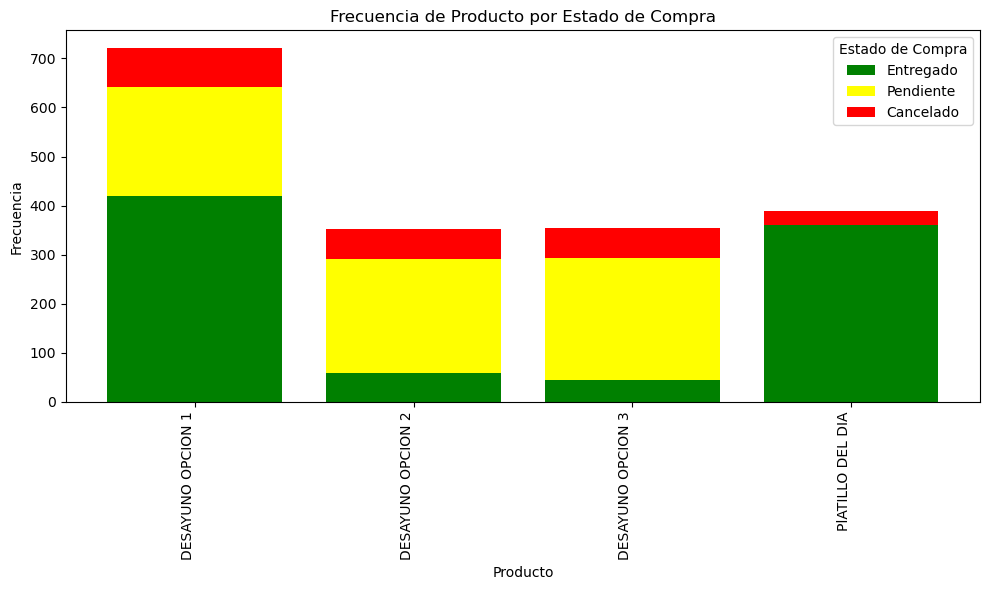

In [36]:
# Filtrar los productos por "Paquetes"
agrupado_producto = caf[caf["Categoria"] == "Paquetes"]

# Agrupación por Producto y Estado, y suma de Cantidades
agrupado_categoria = agrupado_producto.groupby(['Producto', 'Estado'])['Cantidad'].sum().unstack(fill_value=0)

# Configuración de colores para los estados
colores = {'Entregado': 'green', 'Pendiente': 'yellow', 'Cancelado': 'red'}

# Configuración del gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Crear barras apiladas por categoría
bottom_bar = None  # Inicializar la base de la barra
for estado, color in colores.items():
    if estado in agrupado_categoria.columns:
        valores = agrupado_categoria[estado]
        ax.bar(agrupado_categoria.index, valores, bottom=bottom_bar, color=color, label=estado)
        bottom_bar = valores if bottom_bar is None else bottom_bar + valores

# Configurar etiquetas y leyenda
ax.set_ylabel('Frecuencia')
ax.set_xlabel('Producto')
ax.set_title('Frecuencia de Producto por Estado de Compra')
ax.legend(title='Estado de Compra')

plt.xticks(rotation=90, ha='right')  # Rotar etiquetas de las categorías
plt.tight_layout()
plt.show()


Después de ahondar en la categoría de Paquetes se puede esclarecer de mejor manera cuáles son los productos que están generando esta perdida en Ventas, tanto el desayuno 2 y desyuno 3 tienen porcentajes extremadamente bajos en las pedidos completadas solo un 15% en promedion por los dos productos y más del 65% en pedidos pendientes. 

Como siguiente paso se seguira analizando esta situación pero ahora a lo largo del tiempo para poder generar teorías.

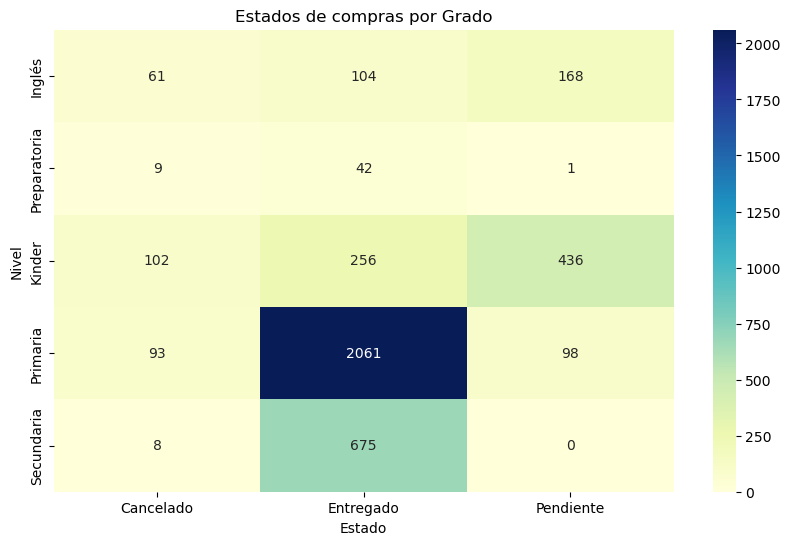

In [37]:
tabla_grayest =pd.crosstab(caf['Nivel'],caf['Estado'])

plt.figure(figsize=(10,6))
sns.heatmap(tabla_grayest, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Estados de compras por Grado')
plt.show()

Gracias al mapa de calor podemos entender de mejor manera cómo es el comportamiento de los alumnos con respecto a sus compras. Notando que lso niveles de Kinder e Inglés son los que mayores pérdidas debido al gran porcentaje que tienen de compras Canceladas y Pendientes.

C:\Users\Carlos\AppData\Local\Temp\ipykernel_12676\3061557710.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  producto_est = agrupado_producto.groupby(["Fecha","Estado"])["Cantidad"].sum().unstack(fill_value=0)


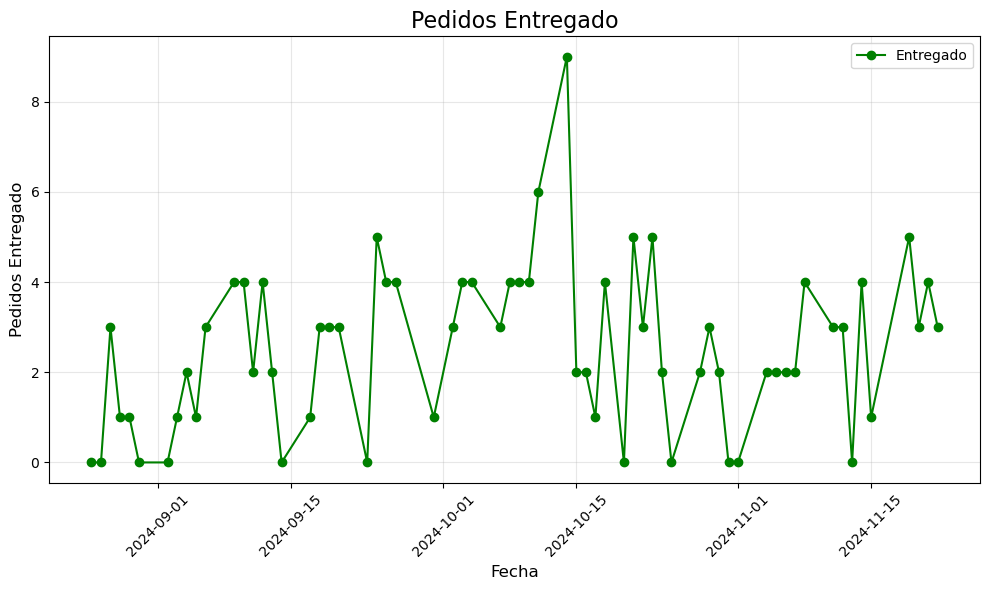

In [38]:
caf['Fecha'] = pd.to_datetime(caf['Fecha'], errors='coerce')
agrupado_producto = caf[(caf["Categoria"] == "Paquetes") & (caf["Nivel"]=="Kinder")]
producto_est = agrupado_producto.groupby(["Fecha","Estado"])["Cantidad"].sum().unstack(fill_value=0)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(producto_est.index, producto_est['Entregado'], marker='o', linestyle='-', color='green', label='Entregado')
plt.title('Pedidos Entregado', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Pedidos Entregado', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\Carlos\AppData\Local\Temp\ipykernel_12676\293971164.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  producto_est = agrupado_producto.groupby(["Fecha","Estado"])["Cantidad"].sum().unstack(fill_value=0)


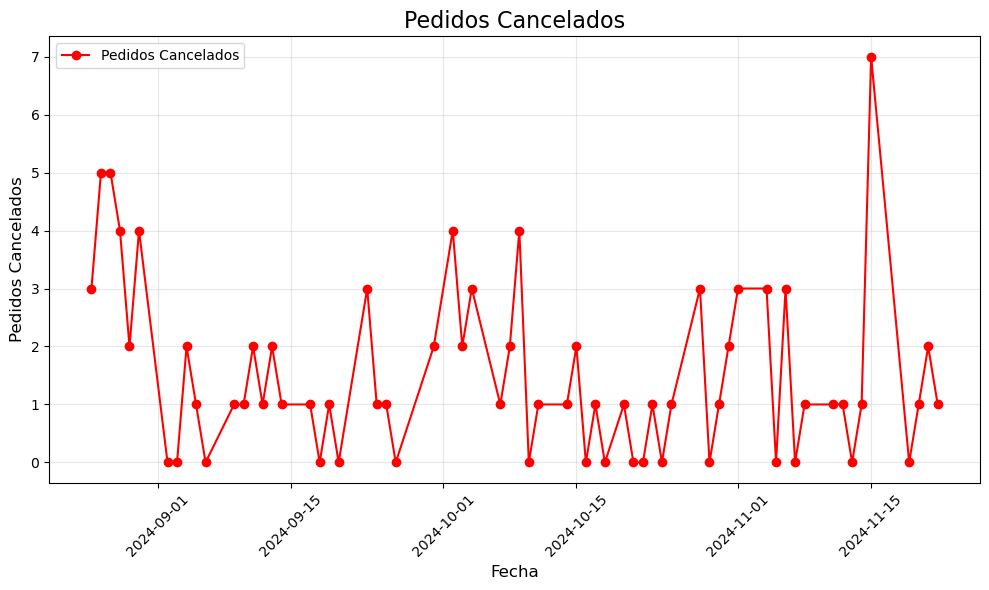

In [39]:
caf['Fecha'] = pd.to_datetime(caf['Fecha'], errors='coerce')
agrupado_producto = caf[(caf["Categoria"] == "Paquetes") & (caf["Nivel"]=="Kinder")]
producto_est = agrupado_producto.groupby(["Fecha","Estado"])["Cantidad"].sum().unstack(fill_value=0)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(producto_est.index, producto_est['Cancelado'], marker='o', linestyle='-', color='red', label='Pedidos Cancelados')
plt.title('Pedidos Cancelados', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Pedidos Cancelados', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\Carlos\AppData\Local\Temp\ipykernel_12676\2571953355.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  producto_est = agrupado_producto.groupby(["Fecha","Estado"])["Cantidad"].sum().unstack(fill_value=0)


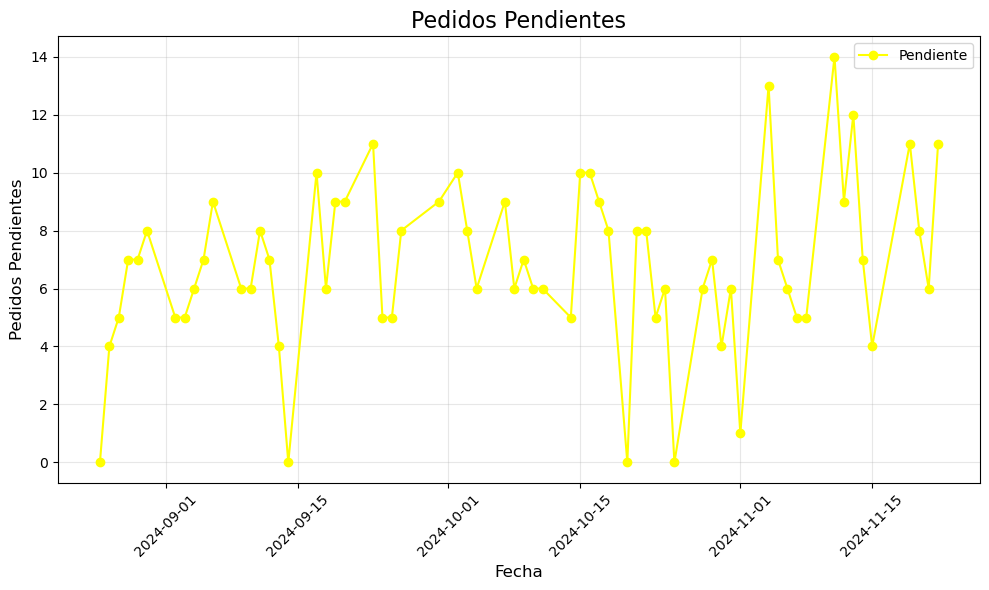

In [40]:
caf['Fecha'] = pd.to_datetime(caf['Fecha'], errors='coerce')
agrupado_producto = caf[(caf["Categoria"] == "Paquetes") & (caf["Nivel"]=="Kinder")]
producto_est = agrupado_producto.groupby(["Fecha","Estado"])["Cantidad"].sum().unstack(fill_value=0)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(producto_est.index, producto_est['Pendiente'], marker='o', linestyle='-', color='yellow', label='Pendiente')
plt.title('Pedidos Pendientes', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Pedidos Pendientes', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
producto_est.index = pd.to_datetime(producto_est.index)
promedio_diario = producto_est.mean()
print(promedio_diario)

Estado
Cancelado    1.515625
Entregado    2.531250
Pendiente    6.796875
dtype: float64


In [42]:
pct_producto = caf[caf["Categoria"] == "Paquetes"]
porc_cat = pct_producto.groupby(['Producto', 'Estado'])["Cantidad"].sum().unstack(fill_value=0)
porc_cat = porc_cat[["Entregado","Pendiente","Cancelado"]]
porc_cat["Total"] = porc_cat.sum(axis=1)
for columna in porc_cat.columns: 
    porc_cat[columna + "_%"] = ((porc_cat[columna]/porc_cat["Total"]) * 100).round(2)
print(porc_cat)

Estado             Entregado  Pendiente  Cancelado  Total  Entregado_%  \
Producto                                                                 
DESAYUNO OPCION 1        420        221         80    721        58.25   
DESAYUNO OPCION 2         60        232         60    352        17.05   
DESAYUNO OPCION 3         44        249         62    355        12.39   
PlATILLO DEL DIA         361          0         28    389        92.80   

Estado             Pendiente_%  Cancelado_%  Total_%  
Producto                                              
DESAYUNO OPCION 1        30.65        11.10    100.0  
DESAYUNO OPCION 2        65.91        17.05    100.0  
DESAYUNO OPCION 3        70.14        17.46    100.0  
PlATILLO DEL DIA          0.00         7.20    100.0  


C:\Users\Carlos\AppData\Local\Temp\ipykernel_12676\272896084.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  porc_cat = pct_producto.groupby(['Producto', 'Estado'])["Cantidad"].sum().unstack(fill_value=0)


In [43]:
est_producto = caf[(caf["Producto"] == "DESAYUNO OPCION 2") & (caf["Nivel"]=="Kinder")]
productoesta = est_producto.groupby(["ID","Estado"])["Cantidad"].sum().unstack(fill_value=0)
filtrop = productoesta[(productoesta.get('Pendiente', 0) > 3) | (productoesta.get('Cancelado', 0) > 0)]
print(filtrop)

Estado                            Cancelado  Entregado  Pendiente
ID                                                               
0b65ee3e2b581b1a022e14e6aae7926a          1          1          1
18c2e3ff3da405bb65b0f8172374be06          5          4          4
1c5c59754b1ac04201d456b8ed26d031          7          0         21
20c5063bf6d1b5fc8d6c896f8c455ca4          1          0          2
2ebcce39eb15e318fc4ae4960dda4470          4          0         19
3e9d1c9063614c4699aaa20bb13d4555          0          3         21
5149ee8038e454d5ba8bacc24912986d          1         10          4
58b93a60ad555fae940e33733ec1740b          0          0         10
58e7e26357d30743c606a8a5ccf1977c          1          1          1
6c456e2c198b2d1d69840243ea967b14          1          0          2
8016e842d970b8b6b5d07e2bf6b15e01          2          1         18
8c9cc168feddb3261991f55dc732f119          1          0         17
a992f92f10be34e20b07555a13a57a30          1          2          1
b7d2b057dc

C:\Users\Carlos\AppData\Local\Temp\ipykernel_12676\719590410.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  productoesta = est_producto.groupby(["ID","Estado"])["Cantidad"].sum().unstack(fill_value=0)


In [44]:
est_producto = caf[(caf["Producto"] == "DESAYUNO OPCION 3") & (caf["Nivel"]=="Kinder")]
productoesta = est_producto.groupby(["ID","Estado"])["Cantidad"].sum().unstack(fill_value=0)
filtrop = productoesta[(productoesta.get('Pendiente', 0) > 3) | (productoesta.get('Cancelado', 0) > 0)]
print(filtrop)

Estado                            Cancelado  Entregado  Pendiente
ID                                                               
070a7de5fda93eb3146863af56eab166          1          0          1
09b4cd68428d0e37aec659b8d5e27416          1          0          1
0b65ee3e2b581b1a022e14e6aae7926a          1          0          0
0c1aa69b31e943bbc51ef641f1634e53          0          0          4
18c2e3ff3da405bb65b0f8172374be06          3          4          5
1c5c59754b1ac04201d456b8ed26d031          2          0          9
20c5063bf6d1b5fc8d6c896f8c455ca4          1          0          9
2ebcce39eb15e318fc4ae4960dda4470          4          0         18
3e9d1c9063614c4699aaa20bb13d4555          1          3         20
5149ee8038e454d5ba8bacc24912986d          2         13          4
58b93a60ad555fae940e33733ec1740b          0          2          6
6c456e2c198b2d1d69840243ea967b14          3          0          2
8016e842d970b8b6b5d07e2bf6b15e01          1          0         18
8c9cc168fe

C:\Users\Carlos\AppData\Local\Temp\ipykernel_12676\3893155053.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  productoesta = est_producto.groupby(["ID","Estado"])["Cantidad"].sum().unstack(fill_value=0)


A diferencia de lo que se esperaba los pedidos cancelados y pendientes han sido estables a lo largo del periodo estudiado, la prinicipal teoría que se tenía era que los días de asueto eran los responsables de estos pedidos, sin embargo se ve como estas fechas no tuvieran influencia notoria en los estados de los pedidos, por lo que se puede suponer que por alguna razón a nivel preescolar las madres que son las que realizan los pedidos "Desconfian" de estos platillos.

Con esta información, se ha obtenido que la media a lo largo de estos 3 meses para los Pedidos Pendientes es de aproximandamente 7 por su parte los pedidos Cancelados de 2, lo que merma bastante las ventas y entorpece la producción de estos platillos.

## Modelado Predictivo

Una vez que los datos han sido limpiados y análizados se encontro que los productos Desayuno Opcion 2 y Desayuno Opcion 3, tienen muy pocas ventas en comparación de los pedidos que han sido cancelados o mantenidos como pendientes. Se ha identificado una posible causa la cual es: 

* Las madres de nivel de Pre-escolar son las realizan los pedidos para los niños más pequeños mostrando desconfianza hacia este tipo de desayuno.

Con base en lo anterior, durante esta sección, se desarrollará un modelo en el cual se predecirá el comportamiento de las madres en los próxmos meses, con el objetivo de así poder tomar una decisión, para saber si es viable mantener o no este producto en el Menú.

In [45]:
productos_e = ["DESAYUNO OPCION 2","DESAYUNO OPCION 3"]
caf_filtrado = caf[caf["Producto"].isin(productos_e)]
#Eliminar filas con  valores  faltantes en estado
caf_filtrado = caf_filtrado.dropna(subset=["Estado"])
print(len(caf_filtrado))

706


In [46]:
#Codificar la columna Estado
encoder = LabelEncoder()
y= encoder.fit_transform(caf_filtrado["Estado"])
print(encoder.classes_)

['Cancelado' 'Entregado' 'Pendiente']


In [47]:
#Se preparan las variables categoricas
X = caf_filtrado[['Nivel','Genero','Fecha','Cantidad']]
X = pd.get_dummies(X, columns=['Nivel','Genero'],drop_first=True)
print(X)

          Fecha  Cantidad  Nivel_Preparatoria  Nivel_Kinder  Nivel_Primaria  \
6    2024-09-18         1               False         False           False   
26   2024-10-07         1               False         False            True   
31   2024-10-08         1               False         False            True   
40   2024-10-30         1               False         False            True   
43   2024-11-06         1               False         False            True   
...         ...       ...                 ...           ...             ...   
4106 2024-09-11         1               False          True           False   
4107 2024-11-06         1               False          True           False   
4109 2024-11-04         1               False          True           False   
4112 2024-09-23         1               False          True           False   
4113 2024-11-08         1               False          True           False   

      Nivel_Secundaria  Genero_M  
6               

In [48]:
#Cambiar el formato de la fecha para que el análisis se realice a nivel día de la semana
X["DiaSemana"] = pd.to_datetime(X["Fecha"]).dt.dayofweek
X["Fecha_Entero"] = (pd.to_datetime(X["Fecha"]) - pd.Timestamp("2020-01-01")).dt.days
X = X.drop(columns=["Fecha"])

In [49]:
#Dividir los datos para el modelos
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=42)

In [50]:
#Entrenar el modelo
mod = RandomForestClassifier(random_state=42)
mod.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [51]:
#Evaluar el modelo
y_pred = mod.predict(X_test)
#Ver la clasificación
print(classification_report(y_test,y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

   Cancelado       0.54      0.47      0.50        30
   Entregado       0.12      0.12      0.12        17
   Pendiente       0.70      0.74      0.72        95

    accuracy                           0.61       142
   macro avg       0.45      0.44      0.45       142
weighted avg       0.60      0.61      0.60       142



In [52]:
#Matriz de confusión
print(confusion_matrix(y_test,y_pred))

[[14  1 15]
 [ 0  2 15]
 [12 13 70]]


## Interpretación de los Resultados
Interpretando los datos obtenidos de la predicción, el modelo no es lo suficientemente bueno para hacer predicciones en 2 de 3 clases, esto se debe principalmente a que los datos están desbalanceados, ya que la naturaleza de los datos obliga a encontrar más valores "Entregados" aunado a que este data-set en su forma principal contiene pocos datos.

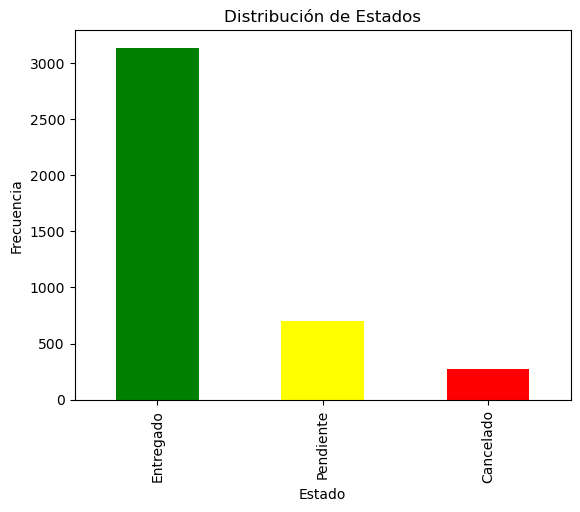

In [54]:
caf['Estado'].value_counts(normalize=True)
caf['Estado'].value_counts().plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Distribución de Estados')
plt.xlabel('Estado')
plt.ylabel('Frecuencia')
plt.show()

## Mejoras Futuras
Debido a las limitaciones tanto técnicas como tecnologicas así como el objetivo principal de este proyecto, el modelo no será modificado. No obstante, se es consciente de que éste se puede mejorar en dado caso para su uso, pero con base en lo comentado previamente y debido a la escazes de los datos, se utilizará el modelo tal y como se tiene ahora, aunque sea para hacerse una idea general de la situación.

Para mejorar el modelo de predicción en un futuro se tiene planeado recolectar más datos, ya que los datos utilizados han sido recabados a través de la app de la cafetería la cual a día de hoy muestra un 25% de las ventas que se generan en la misma. Con una mayor cantidad de datos seguiría habiendo desproporción en las clases, sin emabrgo sería mucho más fácil la manipulación de éstas. Otra alternativa que se presenta sería evaluar la posibilidad de cambiar de técnicas de modelado una vez que se identifique a mayor profundidad los datos así como las relaciones que estos presentan, teniendo como opciones:  Random Forest, Gradient Boosting.

## Conclusiones

A lo largo del proyecto se realizo la limpieza de los datos que se tenían, dandoles el formato necesario para su correcta interpretación, así cómo elimnando los datos que no son de utilidad y creando los parametros que serían utilizados durante el análisis. Cabe resaltar la importancia de un proceso adecuado de recopilación y mantenimiento de los mismos ya que en un futuro se tiene planeado que las ventas se realicen totalmente a través de la app, lo cual siguiendo con los estandarés ahora implementados, podrían generar problemas en su interpretación o simplemente retardamiento en el mismo.

El objetivo principal era realizar el análisis que pudieran presentarnos cómo los estudiantes han desarrollado sus compras dentro de la app a lo largo del periodo, no obstante mientras se realizaba el análisis se encontro con un problema mucho mayor que demanda ser atendido antes. En el nivel kinder los pedidos en su mayoría se encuentran en un estado de entrega "Pendiente",puntualmente en los productos "DESAYUNO OPCION 2" y "DESAYUNO OPCION 3" esta situación genera perdidas de ventas y entorpece los diferente procesos de recolección, preparación y entrega de los productos, lo cual significa pérdidas monetarias para el negocio. Se realizó un modelo de predicción de manera general el cual arrojo que durante los próximos meses si no se toman las acciones perrtinentes estos pedidos se mantendrán a la alza. (No se incluyo la predicción debido a que la empresa asi lo quiso.) 

El hecho de atender el problema permitirá entender cuál es la razón por la cuál las madres que son las que se encargan de hacer estos pedidos, suelen mantener en "Pendiente" las entregas de los productos, lo anterior abrirá paso no sólo a bajar el gran porcentaje de Entregas Pendientes, sino que además podra servir como punto de partida para crear un mejor perfil de los clientes a nivel general dandoles opciones personalizadas que se traduce en mayores ventas. 